<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/DLL_HW_11_CV_NOISE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLL

## Домашняя работа 11 | CV-3

## Иванов Денис

###Задание 
Возьмите MNIST, обучите на нем LeNet

Обучите шум, который при добавлении к оригинальной картинке MNIST, заставит модель ошибаться в пользу другого класса

### 1. Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import random

import matplotlib.pyplot as plt

In [ ]:
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"work on {(torch.cuda.get_device_name() if dev.type == 'cuda' else 'cpu')}")

work on cpu


### 2. Загрузка данных

In [ ]:
def load_mnist():
    train_data = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                                            ]))
    test_data = datasets.MNIST('data', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                                            ]))
    return train_data, test_data


def load_data(train_batch_size, test_batch_size):
    train_data, test_data = load_mnist()
    train_loader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=train_batch_size, 
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(test_data, 
                                              batch_size=train_batch_size, 
                                              shuffle=False)

    return (train_loader, test_loader)

### 3. MNIST to LeNet



#### 3.1. Конфигурация и базовые функции 

##### https://www.kaggle.com/vincentman0403/pytorch-v0-3-1b-on-mnist-by-lenet

In [ ]:
class LeNet(nn.Module):  # try LeNet from DLL11
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)      
        self.fc1 = nn.Linear(16 * 5 * 5, 120)          
        self.fc2 = nn.Linear(120, 84)         
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)   
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_fn = torch.nn.CrossEntropyLoss()#size_average=False) 
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss = loss_fn(output, target)
        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()
    test_loss /= len(test_loader.dataset)
    print('Test set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### 3.2.  Обучение LeNet

In [ ]:
torch.manual_seed(123)

model = LeNet()

lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr)

train_batch_size = 1000
test_batch_size  = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

epochs       = 5
log_interval = 100
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader, log_interval=log_interval)
    test(model, epoch, test_loader)

Test set, Epoch 1 , Average loss: 0.0002, Accuracy: 4414/10000 (44%)
Test set, Epoch 2 , Average loss: 0.0000, Accuracy: 9337/10000 (93%)
Test set, Epoch 3 , Average loss: 0.0000, Accuracy: 9567/10000 (96%)
Test set, Epoch 4 , Average loss: 0.0000, Accuracy: 9657/10000 (97%)
Test set, Epoch 5 , Average loss: 0.0000, Accuracy: 9720/10000 (97%)


In [ ]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 4.  Обучение шума

#### 4.1.  Вариант 1

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.line = nn.Linear(1024,1024)
    def forward(self, input):
        x = self.line(input.flatten())
        x = x.view((32,32))
        return x

In [ ]:
noise_m = torch.zeros((32,32))

In [ ]:
def check_attack(idx, n_iters = 10, step =2):
    model_noise  = Net1()
    optim = torch.optim.Adam(model_noise.parameters(), lr = .1)
    crit  = torch.nn.CrossEntropyLoss()
    
    X   = test_data[idx][0].unsqueeze(0).float() 
    X_in= X.squeeze().detach().cpu().numpy()
    y   = torch.tensor(test_data[idx][1]).unsqueeze(0).type(torch.long)

    for iter in range(n_iters):
        model_noise.train()    
        optim.zero_grad()
        X_out     = (X + model_noise(noise_m)).float() 
        # X_out     = torch.clamp(X_out, 0, 1)
        pred      = model(X_out) 
        true_loss = crit(pred, y)
        loss      = torch.exp(-true_loss) 
        loss.backward()
        optim.step()

        if iter in range(1, n_iters, step):
            X_out = X_out.squeeze().detach().cpu().numpy()
            fig, axs = plt.subplots(1, 3, figsize=(6,18))     
            axs[0].imshow(X_in)
            axs[1].imshow(X_out-X_in)
            axs[2].imshow(X_out)
            plt.title(f'{y[0].item()} -> {model(X + model_noise(noise_m))[0].argmax().item()}')
            plt.show()     
            print(model(X).argmax().item())                       
            print(f'iter {iter}, loss = {true_loss}')

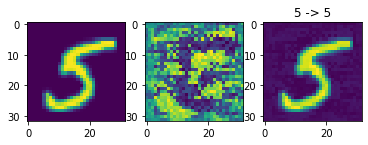

5
iter 1, loss = 3.814624506048858e-05


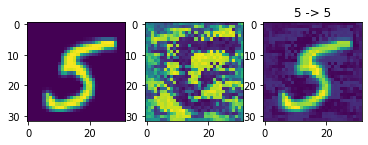

5
iter 3, loss = 0.0008822362869977951


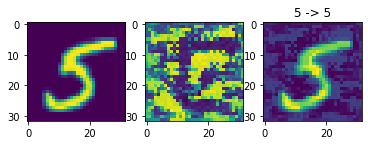

5
iter 5, loss = 0.019064757972955704


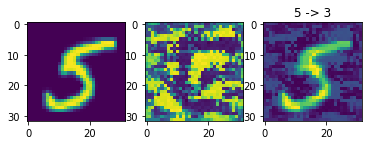

5
iter 7, loss = 0.3167945146560669


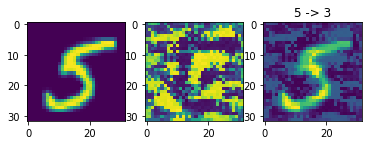

5
iter 9, loss = 2.3099043369293213


In [ ]:
check_attack(5632)

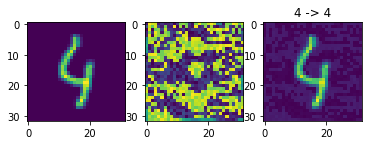

4
iter 1, loss = 0.07527671754360199


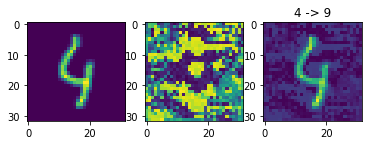

4
iter 3, loss = 0.8941103219985962


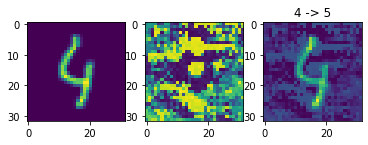

4
iter 5, loss = 4.209260940551758


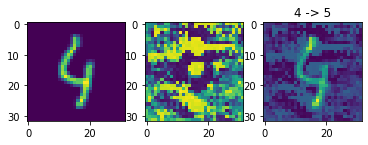

4
iter 7, loss = 7.031081199645996


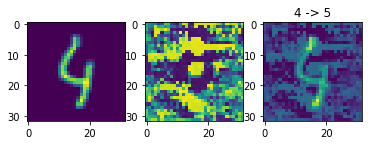

4
iter 9, loss = 8.439919471740723


In [ ]:
check_attack(3571)

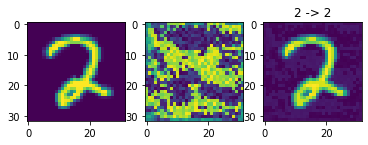

2
iter 1, loss = 0.0006565084331668913


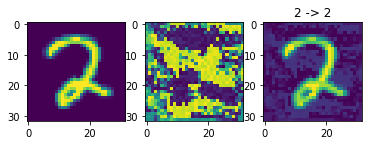

2
iter 3, loss = 0.010040727443993092


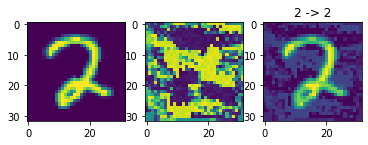

2
iter 5, loss = 0.13037624955177307


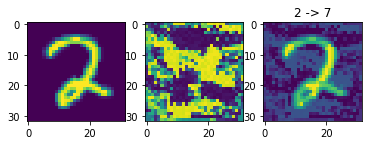

2
iter 7, loss = 1.0036672353744507


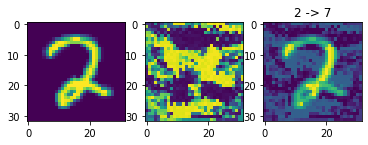

2
iter 9, loss = 3.622838020324707


In [ ]:
check_attack(3257)

#### 4.2.  Вариант 2

In [ ]:
test_data = load_mnist()[1]

In [ ]:
def check_attack(idx, n_iters = 10, step =1):
    noise = torch.nn.Linear(32, 32, bias=False)
    optim = torch.optim.Adam(noise.parameters(), lr = .1)
    crit  = torch.nn.CrossEntropyLoss()
    noise.train()
    X   = test_data[idx][0].unsqueeze(0).float() 
    X_in= X.squeeze().detach().cpu().numpy()
    y   = torch.tensor(test_data[idx][1]).unsqueeze(0).type(torch.long)

    for iter in range(n_iters):

        optim.zero_grad()
        X_out       = (X + noise.weight).float() 
        pred        = model(X_out) 
        true_loss   = crit(pred, y)
        loss        = torch.exp(-true_loss) 
        loss.backward()
        optim.step()

        if iter in range(1, n_iters, step):
            X_out = X_out.squeeze().detach().cpu().numpy()
            fig, axs = plt.subplots(1, 3, figsize=(6,18))     
            axs[0].imshow(X_in)
            axs[1].imshow(X_out-X_in)
            axs[2].imshow(X_out)
            plt.title(f'{y[0].item()} -> {model(X_out)[0].argmax().item()}')
            plt.show()     
                      
            print(f'iter {iter}, loss = {true_loss}')

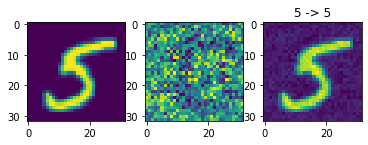

5
iter 1, loss = 3.886147169396281e-05


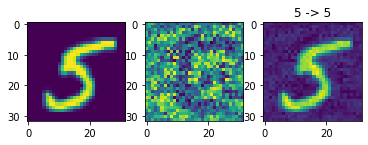

5
iter 2, loss = 0.00019095504831057042


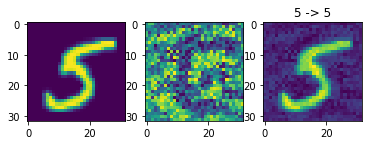

5
iter 3, loss = 0.0009640575153753161


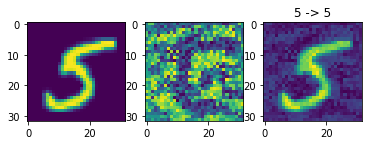

5
iter 4, loss = 0.004649660550057888


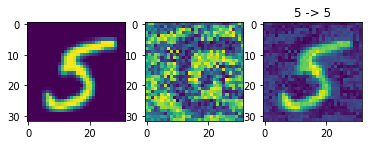

5
iter 5, loss = 0.021705690771341324


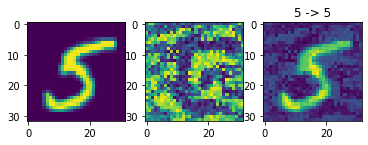

5
iter 6, loss = 0.08968387544155121


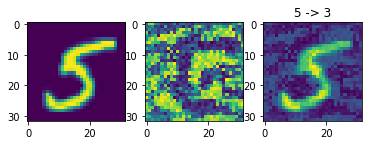

5
iter 7, loss = 0.34842976927757263


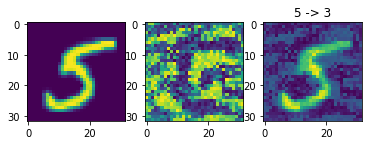

5
iter 8, loss = 1.0723589658737183


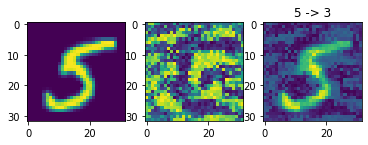

5
iter 9, loss = 2.423001766204834


In [ ]:
check_attack(5632, n_iters = 10)

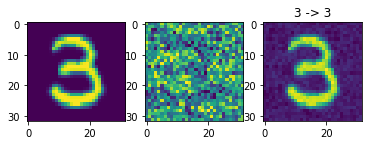

3
iter 1, loss = 0.00010942813969450071


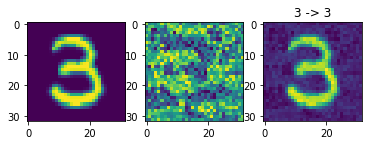

3
iter 2, loss = 0.00047183825518004596


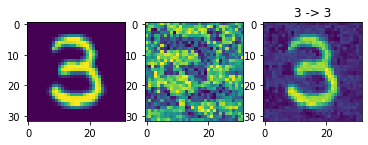

3
iter 3, loss = 0.0018500846344977617


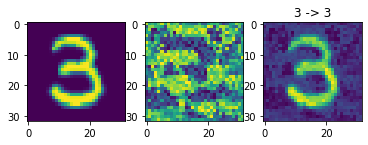

3
iter 4, loss = 0.006333517376333475


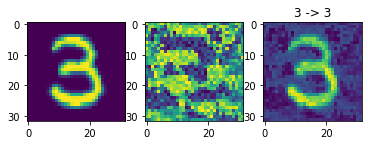

3
iter 5, loss = 0.020425574854016304


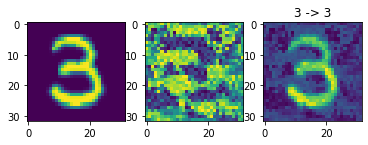

3
iter 6, loss = 0.06565721333026886


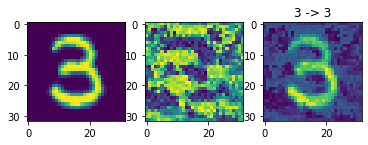

3
iter 7, loss = 0.20135699212551117


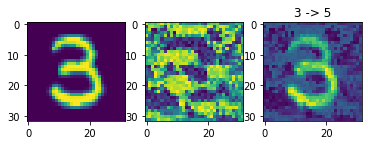

3
iter 8, loss = 0.5513515472412109


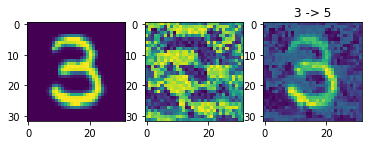

3
iter 9, loss = 1.2822076082229614


In [ ]:
check_attack(3579)

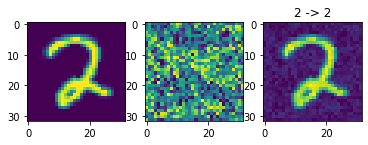

2
iter 1, loss = 0.0006386386230587959


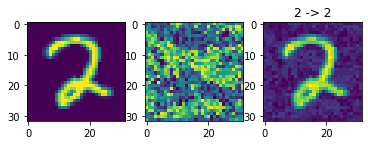

2
iter 2, loss = 0.002589327748864889


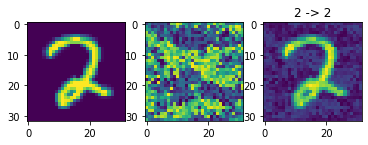

2
iter 3, loss = 0.010404394008219242


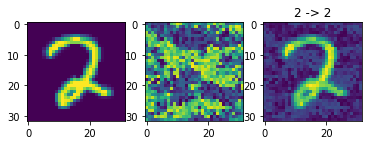

2
iter 4, loss = 0.03853865712881088


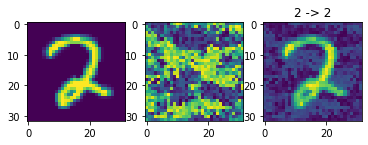

2
iter 5, loss = 0.13635295629501343


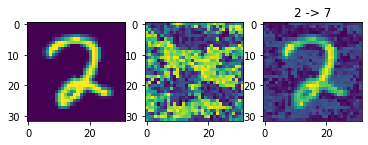

2
iter 6, loss = 0.4070875942707062


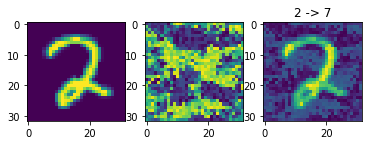

2
iter 7, loss = 1.0495221614837646


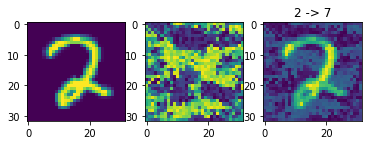

2
iter 8, loss = 2.263246536254883


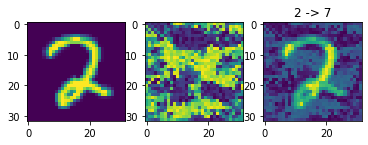

2
iter 9, loss = 3.7672345638275146


In [ ]:
check_attack(3257)